In [156]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *

In [157]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [158]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [159]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of **unconditional** image generation.

In [160]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [161]:
from diffusers import UNet2DModel

In [7]:
n_steps=1000
# original
#beta_min=0.0001
#beta_max=0.02

beta_min=0.0001
beta_max=0.02

beta = torch.linspace(beta_min, beta_max, n_steps).to(def_device)
alpha = 1.0 - beta
alphabar = torch.cumprod(alpha, dim=0)
sigma = beta.sqrt()

In [ ]:
# code in Learner/callback will have added dimension to deal with batches, this snippet only handles one image
t=torch.randint(0, n_steps, (1,), device=def_device, dtype=torch.long)
results = []
for t in range(0,1000,10):
    noise = torch.randn((1,32,32), device=def_device)
    x0 = xb[0].to(def_device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1) # broadcast alphabar to whole channel
    x_t = alphabar_t.sqrt() * x0 + (1-alphabar_t).sqrt() * noise # weighted average between original image and noise, where the weights vary with time
    results.append((x_t, f't={t}'))
ims, titles = tuple(zip(*results))
show_images(ims, 10,10, imsize=1.0, titles=titles)

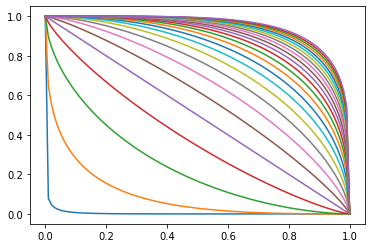

In [225]:
x=torch.linspace(0,1,100)
y=[]
for n in torch.linspace(0.2, 5, 25):
    #y.append(((1-(1 - x**n) ** (1/n)) * 1.5 + 1e-4).clamp(0,1))
    vals = (1 - x**n) ** (1/n)
    y.append((vals, n))
#y = y/y.max()
for yi in y:
    plt.plot(x,yi[0])
#plt.legend(list(zip(*y))[1])

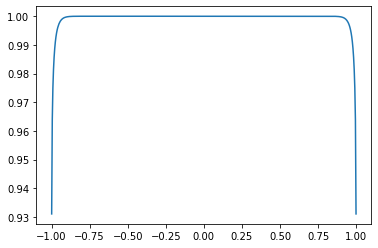

In [224]:
x=torch.linspace(-2, 2, 1000)
n=44
vals = (1 - x**n) ** (1/n)
plt.plot(x,vals)

<BarContainer object of 100 artists>

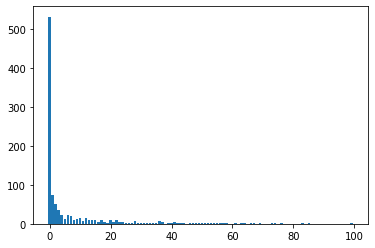

In [151]:
bins=100
hist = torch.histc(y, bins)
plt.bar(range(bins), hist)

In [8]:
# copied whole cell since I handwrote (or will handwrite) the equivalent logic in REPL form
# for both methods
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [176]:
# copied whole cell since I handwrote (or will handwrite) the equivalent logic in REPL form
# for both methods
class DDPMCB_crazy(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        rand_scale = random.random()
        # prob dist to use. weights towards mostly close to 0.
        random_scale = torch.rand(tuple())
        random_scale=((1-(1 - random_scale**n) ** (1/n)) * 1.5 + 1e-4).clamp(0,1)
        xt = (1 - rand_scale) * x0 + rand_scale * ε #noisify the image

        # fix "timestep" to always 0 so model learns to ignore it
        learn.batch = ((xt, torch.zeros(xt.shape[0], device=def_device)), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

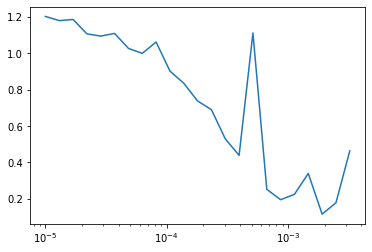

In [177]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB_crazy(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB()]#, BatchSchedCB(sched)]
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.lr_find()

In [178]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))

loss,epoch,train
0.181,0,train
0.102,0,eval
0.067,1,train
0.063,1,eval


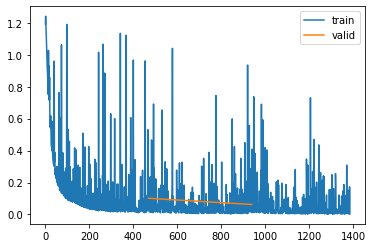

KeyboardInterrupt: 

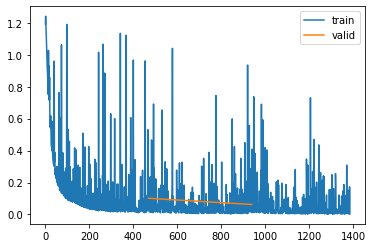

In [179]:
'''
Note: different from Tanishq's LR (4e-3) because it's the LR before loss begins to 
decrease

Update: first time training this, like mentioned above, used lr=1e-2. But second 
training didn't converge, loss stayed flat at 1 (probably meaning random chance
given the MSELoss for these black and white pixels). So going back to 4e-3.

(screwed around with it more after trying ddpmcb_crazy. It didn't work.)
'''
lr = 1e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
'''
TODO: try changing beta_max to 0.0002, which is the value that preserved the pattern of
the image more visibly throughout training schedule

Update: tried that by accident and while it seems to work ok for training, getting good loss,
it does poorly for sampling. Generates junk, fixing beta_max to Tanishq's worked.
'''
ddpm_cb = DDPMCB_crazy(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)
learn.fit(epochs)

In [9]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [13]:
#torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [9]:
model = torch.load(Path('../../p2/nbs/models')/'fashion_ddpm.pkl')

In [15]:
#learn.fit(1, do_train=False)

In [16]:
#samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
#show_images(samples[-1], figsize=(10,10))

In [17]:
#samples_t=torch.stack(samples)
#show_images(samples_t[0:1000:10, 3], figsize=(10, 10))

In [18]:
# New stats including timeshifted tensors for sampling
betabar = 1.0 - alphabar
tsr_alphabar_tneg1 = torch.cat((tensor(1)[None].to('cuda'), alphabar[:-1],))
tsr_betabar_tneg1 = 1.0 - tsr_alphabar_tneg1

x0_coeff = tsr_alphabar_tneg1.sqrt() * (1.0 - alpha) / betabar
xt_coeff = alpha.sqrt() * tsr_betabar_tneg1 / betabar

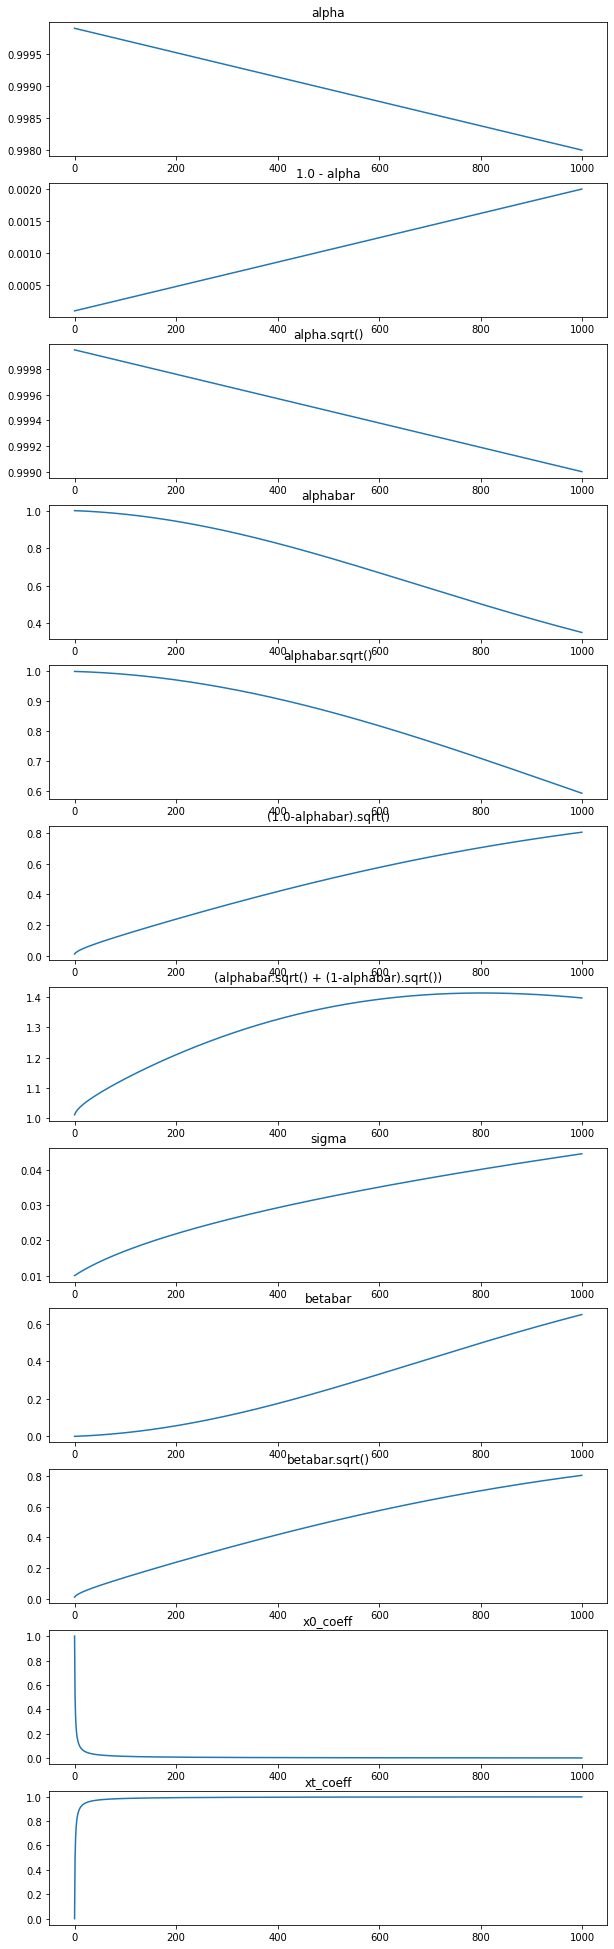

In [19]:
stats = [
    (alpha, 'alpha'),
    (1.0 - alpha, '1.0 - alpha'),
    (alpha.sqrt(), 'alpha.sqrt()'),
    (alphabar, 'alphabar'),
    (alphabar.sqrt(), 'alphabar.sqrt()'),
    ((1.0-alphabar).sqrt(), '(1.0-alphabar).sqrt()'),
    ((alphabar.sqrt() + (1-alphabar).sqrt()), '(alphabar.sqrt() + (1-alphabar).sqrt())'),
    (sigma, 'sigma'),
    (betabar, 'betabar'),
    (betabar.sqrt(), 'betabar.sqrt()'),
    (x0_coeff, 'x0_coeff'),
    (xt_coeff, 'xt_coeff'),
]

_,axes = plt.subplots(len(stats), 1, figsize=(10,35))

for i,(data, title) in enumerate(stats):
    axes[i].plot(data.cpu())
    axes[i].title.set_text(title)

In [44]:
samples=None
samples_t=None
ims,titles,results=None,None,None
clean_mem()

In [42]:
beta_min,beta_max

(0.0001, 0.002)

In [17]:
t=torch.ones((1,1,3,4))
t.shape,t[0,0].shape

(torch.Size([1, 1, 3, 4]), torch.Size([3, 4]))

In [18]:
# bad results trying with beta_max=0.002, try now with 0.02
with torch.no_grad():
    x_t=torch.randn((1,1,32,32)).to(def_device)
    preds=[]
    for t in reversed(range(n_steps)):
        if t % 5 == 0:
            print(f'{t}...', end='')
        t=tensor(t, dtype=torch.long, device=def_device)
        noise = torch.randn(x_t.shape, device=def_device)
        alphabar_tneg1 = alphabar[t-1]
        betabar_t = 1.0 - alphabar[t]
        betabar_tneg1 = 1.0 - alphabar_tneg1

        x0_hat = ((x_t - betabar_t.sqrt() * model(x_t, t).sample) / alphabar[t].sqrt()).clamp(-1, 1)

        x0_coeff = alphabar_tneg1.sqrt() * (1.0 - alpha[t]) / betabar_t
        xt_coeff = alpha[t].sqrt() * betabar_tneg1 / betabar_t

        x_t = x0_coeff * x0_hat + x_t * xt_coeff + sigma[t] * noise
        preds.append(x_t[0,0].cpu())

995...990...985...980...975...970...965...960...955...950...945...940...935...930...925...920...915...910...905...900...895...890...885...880...875...870...865...860...855...850...845...840...835...830...825...820...815...810...805...800...795...790...785...780...775...770...765...760...755...750...745...740...735...730...725...720...715...710...705...700...695...690...685...680...675...670...665...660...655...650...645...640...635...630...625...620...615...610...605...600...595...590...585...580...575...570...565...560...555...550...545...540...535...530...525...520...515...510...505...500...495...490...485...480...475...470...465...460...455...450...445...440...435...430...425...420...415...410...405...400...395...390...385...380...375...370...365...360...355...350...345...340...335...330...325...320...315...310...305...300...295...290...285...280...275...270...265...260...255...250...245...240...235...230...225...220...215...210...205...200...195...190...185...180...175...170...165.

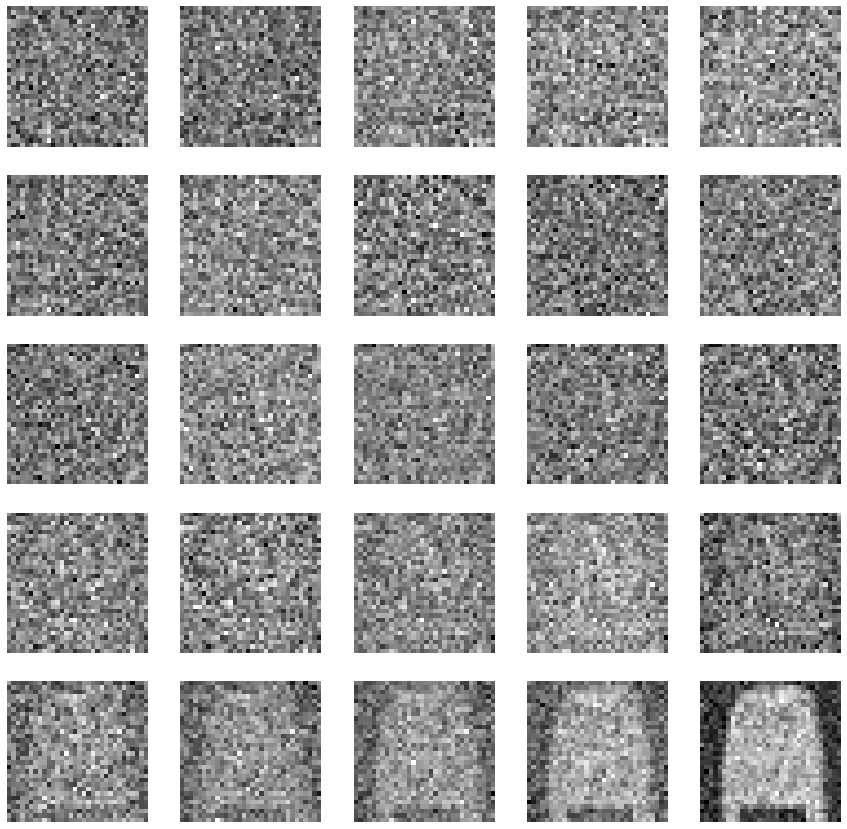

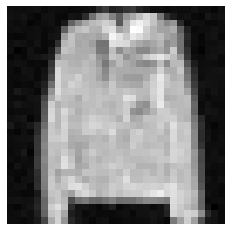

In [33]:
show_images(preds[::40] + [preds[-1]], 5, 5)